<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Столбцы-к-нижнему-регистру" data-toc-modified-id="Столбцы-к-нижнему-регистру-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Столбцы к нижнему регистру</a></span></li><li><span><a href="#Дубликаты" data-toc-modified-id="Дубликаты-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Дубликаты</a></span></li><li><span><a href="#Пропуски" data-toc-modified-id="Пропуски-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Пропуски</a></span></li></ul></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Треды-и-сезонность" data-toc-modified-id="Треды-и-сезонность-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Треды и сезонность</a></span></li><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Матрица-корреляции" data-toc-modified-id="Матрица-корреляции-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Матрица корреляции</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Анализ-модели" data-toc-modified-id="Анализ-модели-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Анализ модели</a></span></li><li><span><a href="#Анализ-важности-признаков" data-toc-modified-id="Анализ-важности-признаков-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Анализ важности признаков</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

!pip install phik -q
!pip install shap
!pip install --upgrade shap
!pip install --upgrade numba
!pip install seaborn==0.13.2
!pip install imbalanced-learn==0.10.1
!pip install scikit-learn==1.2.2
!pip install xgboost lightgbm

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
import seaborn as sns
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder

# загружаем функцию для работы с метриками
from sklearn.metrics import mean_squared_error

# загружаем нужные модели
from lightgbm import LGBMRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor


import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

from math import sqrt

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import shap

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import TimeSeriesSplit

## Подготовка

In [2]:
try:
    taxi = pd.read_csv('/datasets/taxi.csv',parse_dates = [0], index_col = [0])
except:
    taxi = pd.read_csv('taxi.csv',parse_dates = [0], index_col = [0])
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


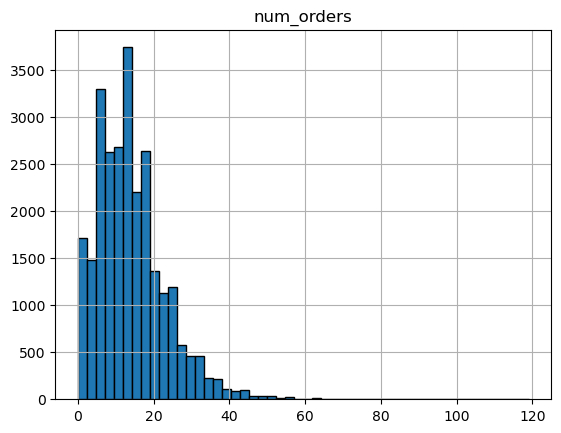

In [4]:
taxi.hist(bins = 50, ec = 'black');

Типы данных установлены правильно, установили столбец datetime - как index

## Анализ

### Столбцы к нижнему регистру

In [5]:
taxi.columns = taxi.columns.str.lower().str.replace(' ','_')
taxi.columns

Index(['num_orders'], dtype='object')

### Дубликаты

In [6]:
taxi.duplicated().sum()

26415

Дубликаты могут быть, поэтому их не удаляем

### Пропуски

In [7]:
taxi.isna().sum()

num_orders    0
dtype: int64

Пропусков не имеем 

Вывод:
- сделали как индекс - datetime
- Не видим пропуски
- привели столбцы книжнему регистру
- Дубликаты могут быть, поэтому их не удаляем

## Исследовательский анализ данных

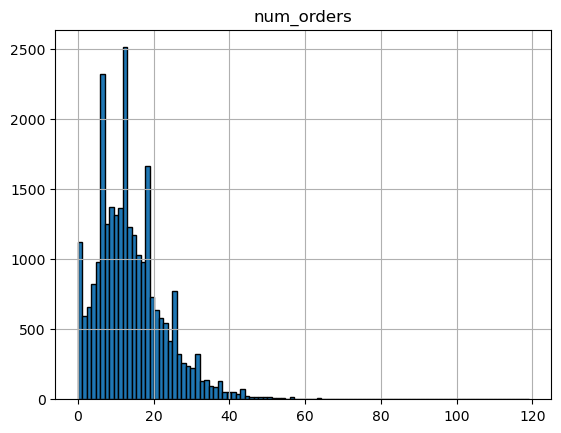

In [8]:
taxi.hist(bins = 100, ec = 'black');

In [9]:
taxi.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


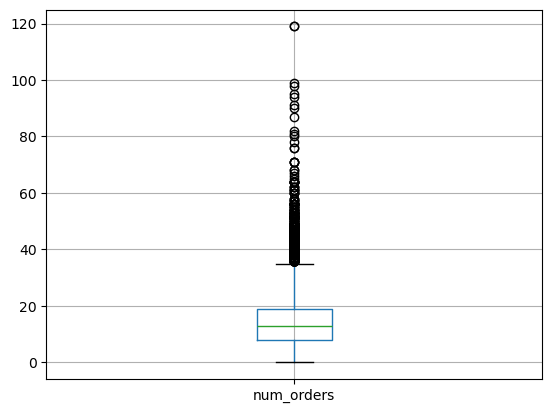

In [10]:
taxi.boxplot();

In [11]:
from ydata_profiling import ProfileReport
profile = ProfileReport(taxi, title="Profiling Report", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Вывод:
- максимальное количество заказов - 119
- минимальное - 0 
и то, и то - возможно, человек может заказывать такси почти каждый день или скачать приложение и не покататься вовсе

## Треды и сезонность

In [12]:
taxi.index.year.unique(),taxi.index.month.unique()

(Index([2018], dtype='int32', name='datetime'),
 Index([3, 4, 5, 6, 7, 8], dtype='int32', name='datetime'))

Будем рассматривать такси:
- за 2018 год
- с весны по лето

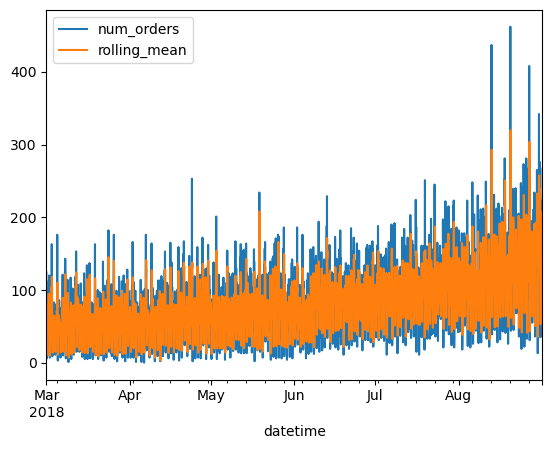

In [13]:
taxi2 = taxi.sort_index(inplace=True)
taxi2 = taxi.resample('1H').sum()
taxi2['rolling_mean'] = taxi2.shift().rolling(3).mean()
taxi2.plot();

Сделали график значений, которые меньше всего подвержены колебаниям, то есть средних арифметических.
Видим возрастание графика

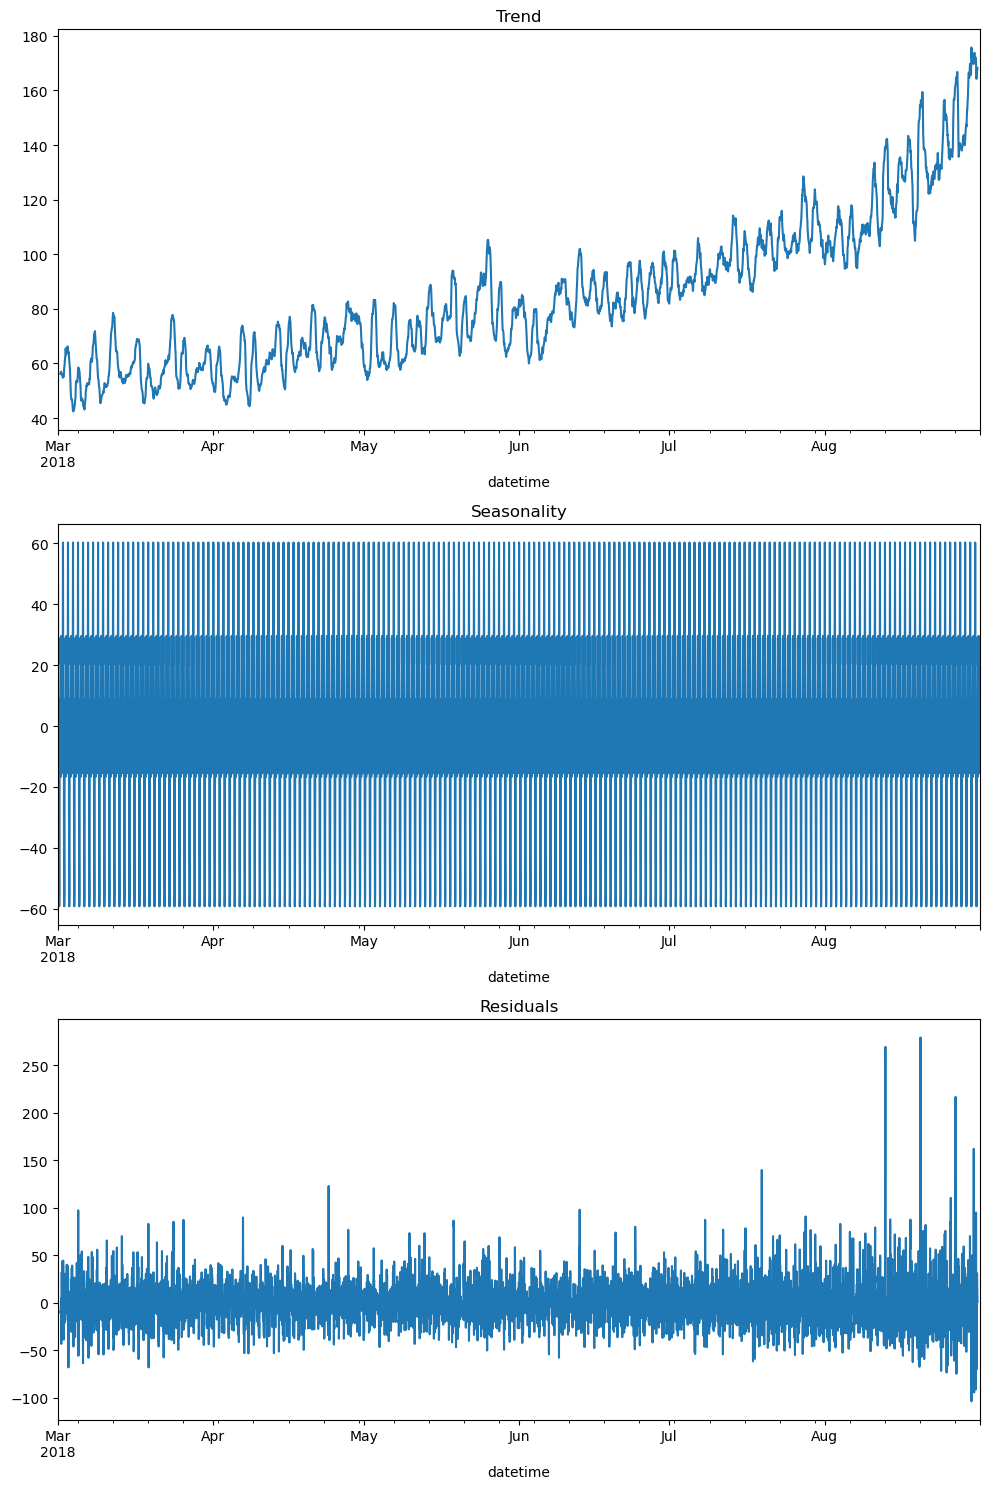

In [14]:
taxi3 = taxi.sort_index(inplace=True)
taxi3 = taxi.resample('1H').sum()

decomposed = seasonal_decompose(taxi3) 

plt.figure(figsize=(10, 15))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем егооси ax, равными plt.gca() (англ. get current axis,получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Тренд:

- Наблюдается положительный тренд, количество заказов постепенно увеличивается с марта по август.
- Тренд не является строго линейным, есть периоды ускорения и замедления.
- Рост числа заказов особенно заметен в мае и июне, а затем немного замедляется в июле, но снова ускоряется в августе.

Сезонность - суточная сезонность:
- Видна периодичность в течение суток, количество заказов больше в ночные часы (возможно, это связано с ночными заказами такси).

Остатки - доля остатков не одинаковая на всем протяжении графика:
- К концу графика доля остатков больше, что может говорить о повышении шума в данных.
- Это может объясняться тем, что тестовая выборка содержит больше данных, которые сложнее объяснить с помощью модели.
- Это может привести к более высокой разнице в RMSE между тренировочной и тестовой выборкой, даже если модель хорошо обучена.

In [15]:
# Проводим тест Дики-Фуллера
result = adfuller(taxi3['num_orders'])

print('ADF Statistic: %f' % result[0])
print(f"p-значение теста Дики-Фуллера: {result[1]}")
if result[1] <= 0.05:
    print("Ряд стационарный")
else:
    print("Ряд, вероятно, нестационарный")

ADF Statistic: -3.068924
p-значение теста Дики-Фуллера: 0.02894005140261296
Ряд стационарный


## Создание признаков  

In [16]:
taxi.sort_index(inplace=True)
taxi = taxi.resample('1H').sum()
def make_features(taxi, max_lag, rolling_mean_size):
    taxi = taxi.copy()
    taxi['dayofweek'] = taxi.index.dayofweek
    taxi['hour'] = taxi.index.hour
    for i in range(1, max_lag + 1):
        taxi[f'lag_{i}'] = taxi['num_orders'].shift(i)

    taxi['rolling_mean'] = taxi['num_orders'].rolling(rolling_mean_size).mean().shift()  # Сначала rolling, затем shift
    return taxi

# Вызываем функцию make_features с ресемплированными данными
taxi2 = make_features(taxi, 168, 24)
taxi2.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Сделали признаки:dayofweek,hour,lag_,rolling_mean

## Обучение

In [17]:
# Выбор признаков и целевого признака
features = [col for col in taxi2.select_dtypes(['int','float']).columns.tolist() if col !='num_orders']
target = 'num_orders'

RANDOM_STATE = 42
TEST_SIZE = 0.1
train,test = train_test_split(taxi2, shuffle=False, test_size = TEST_SIZE)

num_col = [col for col in taxi2.select_dtypes(['int','float']).columns.tolist() if col !='num_orders']

train = train.dropna()

data_preproccesor = ColumnTransformer(
    [('num', MinMaxScaler(), num_col)], 
    remainder='passthrough'
)

pipe_final = Pipeline([('preprocessor',data_preproccesor),
                      ('models', LinearRegression())])
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 12),
        'models__min_samples_leaf':range(2, 12),
        'models__min_samples_split':range(2, 12),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    {'models': [LGBMRegressor(random_state=RANDOM_STATE)],
             'learning_rate': np.logspace(-3, 0, 5), 
             'n_estimators': range(20, 61, 20), 
             'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]},
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {'models': [GradientBoostingRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200],
        'models__learning_rate': [0.1, 0.01],
        'models__max_depth': range(2, 6), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]},

]

randomized_search = RandomizedSearchCV(pipe_final,
                                       param_grid,
                                       cv=TimeSeriesSplit(n_splits=10),
                                       scoring='neg_root_mean_squared_error',
                                       random_state=RANDOM_STATE,
                                       n_jobs=-1,
                                       error_score='raise')

In [18]:
%%time
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

randomized_search.fit(X_train, y_train)
print(f'Лучшая модель:{randomized_search.best_estimator_}')
print(f'Лучший RMSE на тренировочных:{randomized_search.best_score_ * -1}')

y_pred = randomized_search.predict(X_test)

Лучшая модель:Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['dayofweek', 'hour', 'lag_1',
                                                   'lag_2', 'lag_3', 'lag_4',
                                                   'lag_5', 'lag_6', 'lag_7',
                                                   'lag_8', 'lag_9', 'lag_10',
                                                   'lag_11', 'lag_12', 'lag_13',
                                                   'lag_14', 'lag_15', 'lag_16',
                                                   'lag_17', 'lag_18', 'lag_19',
                                                   'lag_20', 'lag_21', 'lag_22',
                                                   'lag_23', 'lag_24', 'lag_25',
                                                   'lag_26', 'lag_27', 'lag_28', ...])])),
        

## Анализ модели

In [19]:
randomized_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['dayofweek', 'hour', 'lag_1',
                                                   'lag_2', 'lag_3', 'lag_4',
                                                   'lag_5', 'lag_6', 'lag_7',
                                                   'lag_8', 'lag_9', 'lag_10',
                                                   'lag_11', 'lag_12', 'lag_13',
                                                   'lag_14', 'lag_15', 'lag_16',
                                                   'lag_17', 'lag_18', 'lag_19',
                                                   'lag_20', 'lag_21', 'lag_22',
                                                   'lag_23', 'lag_24', 'lag_25',
                                                   'lag_26', 'lag_27', 'lag_28', ...])])),
                ('models',
                 DecisionTreeRegressor(max_depth=4, min_samples_leaf=10,
                                       min_samples_split=4, random_state=42))])

In [20]:
result = pd.DataFrame(randomized_search.cv_results_).set_index('params')
result.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__min_samples_split,param_models__min_samples_leaf,param_models__max_depth,param_models,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
params,,,,,,,,,,,,,,,,,,,,,
"{'preprocessor__num': RobustScaler(), 'models__min_samples_split': 4, 'models__min_samples_leaf': 10, 'models__max_depth': 4, 'models': DecisionTreeRegressor(random_state=42)}",0.178893,0.055599,0.015363,0.003255,RobustScaler(),4,10,4,DecisionTreeRegressor(random_state=42),-21.560677,...,-25.072023,-25.270100,-23.425967,-23.702087,-23.391751,-31.542343,-33.062048,-25.221478,3.744954,1
"{'preprocessor__num': 'passthrough', 'models__min_samples_split': 5, 'models__min_samples_leaf': 9, 'models__max_depth': 4, 'models': DecisionTreeRegressor(random_state=42)}",0.107473,0.047384,0.008767,0.000984,passthrough,5,9,4,DecisionTreeRegressor(random_state=42),-21.590620,...,-25.072023,-25.528277,-23.542229,-23.702087,-23.391751,-31.542343,-33.062048,-25.234471,3.749586,2
"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 7, 'models__min_samples_leaf': 3, 'models__max_depth': 4, 'models': DecisionTreeRegressor(random_state=42)}",0.145759,0.056603,0.018339,0.008554,StandardScaler(),7,3,4,DecisionTreeRegressor(random_state=42),-21.023242,...,-25.610807,-25.231540,-23.594558,-23.702087,-23.391751,-31.542343,-33.062048,-25.270263,3.777167,3
"{'preprocessor__num': RobustScaler(), 'models__min_samples_split': 5, 'models__min_samples_leaf': 4, 'models__max_depth': 5, 'models': DecisionTreeRegressor(random_state=42)}",0.211750,0.069376,0.016950,0.004412,RobustScaler(),5,4,5,DecisionTreeRegressor(random_state=42),-21.452407,...,-26.744317,-23.847729,-23.309150,-24.670879,-24.049457,-30.237723,-34.130278,-25.463828,3.732276,4
"{'preprocessor__num': RobustScaler(), 'models__min_samples_split': 11, 'models__min_samples_leaf': 2, 'models__max_depth': 6, 'models': DecisionTreeRegressor(random_state=42)}",0.244040,0.098484,0.015722,0.002232,RobustScaler(),11,2,6,DecisionTreeRegressor(random_state=42),-22.271420,...,-27.395899,-25.715908,-24.300977,-25.639577,-24.220378,-30.727877,-33.577922,-26.009951,3.493897,5
"{'preprocessor__num': RobustScaler(), 'models__min_samples_split': 5, 'models__min_samples_leaf': 11, 'models__max_depth': 9, 'models': DecisionTreeRegressor(random_state=42)}",0.318190,0.154170,0.015037,0.001811,RobustScaler(),5,11,9,DecisionTreeRegressor(random_state=42),-22.685712,...,-26.071511,-26.935705,-25.047734,-26.485628,-26.956959,-31.839310,-33.326528,-26.525484,3.473346,6
"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 4, 'models__min_samples_leaf': 6, 'models__max_depth': 7, 'models': DecisionTreeRegressor(random_state=42)}",0.290997,0.235934,0.023630,0.027192,MinMaxScaler(),4,6,7,DecisionTreeRegressor(random_state=42),-22.325042,...,-27.878246,-25.983793,-24.396498,-25.884670,-25.939517,-31.811402,-33.949351,-26.612350,3.652911,7
"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 5, 'models__min_samples_leaf': 9, 'models__max_depth': 9, 'models': DecisionTreeRegressor(random_state=42)}",0.267246,0.135218,0.016165,0.003514,StandardScaler(),5,9,9,DecisionTreeRegressor(random_state=42),-22.767107,...,-26.981394,-28.248665,-24.737882,-25.894233,-27.883087,-32.657496,-34.196025,-27.035122,3.690711,8
"{'preprocessor__num': 'passthrough', 'models__min_samples_split': 8, 'models__min_samples_leaf': 9, 'models__max_depth': 10, 'models': DecisionTreeRegressor(random_state=42)}",0.261446,0.144750,0.009959,0.004422,passthrough,8,9,10,DecisionTreeRegressor(random_state=42),-22.598902,...,-26.835544,-28.667382,-24.843003,-26.287340,-28.247447,-32.914896,-34.678215,-27.185936,3.872357,9


## Анализ важности признаков

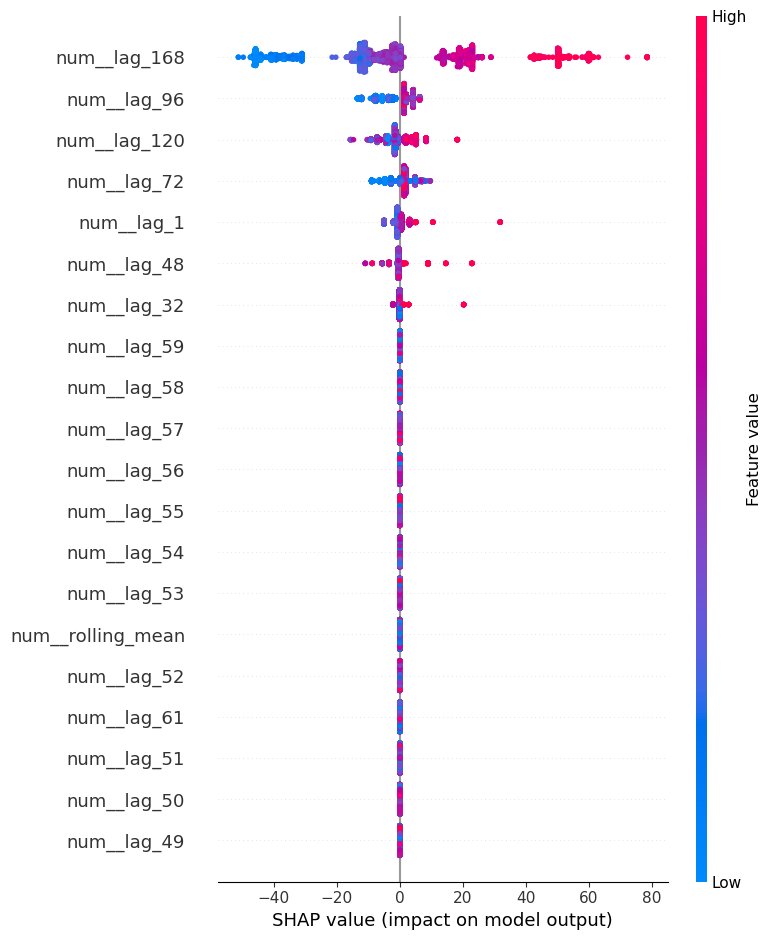

In [21]:
best_pipeline = randomized_search.best_estimator_
preprocessor = best_pipeline.named_steps['preprocessor']
model = best_pipeline.named_steps['models']
preprocessor_col = preprocessor.get_feature_names_out()

X_train_preprocessed = preprocessor.transform(X_train)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed,columns = preprocessor_col)

model.fit(X_train_preprocessed, y_train)

# Создание экземпляра Explainer
explainer = shap.TreeExplainer(model)

# Вычисление SHAP значений
shap_values = explainer.shap_values(X_train_preprocessed)

# Построение summary_plot
shap.summary_plot(shap_values, X_train_preprocessed)

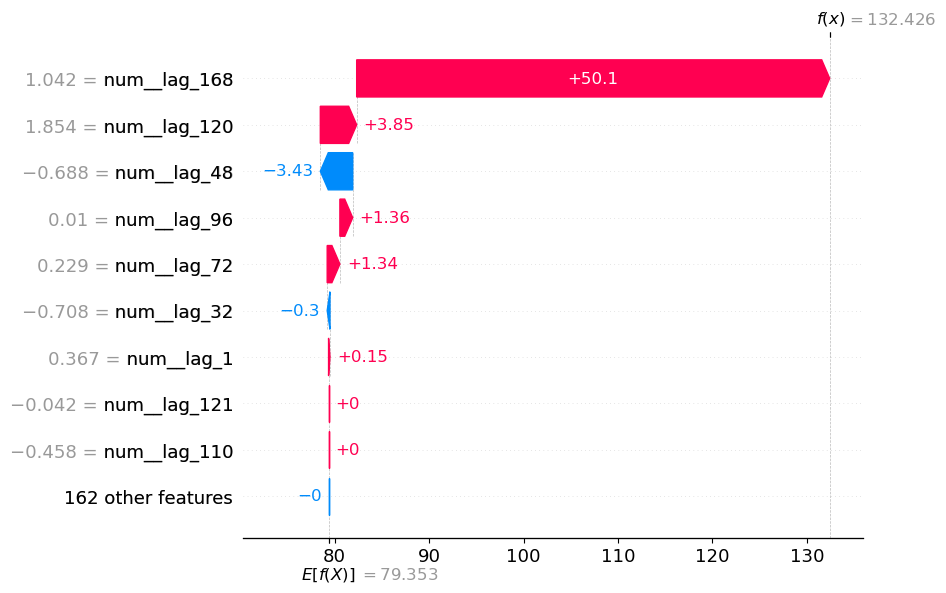

In [22]:
sample_index = 0  
shap.waterfall_plot(shap.Explanation(values=shap_values[sample_index], 
                                         base_values=explainer.expected_value[0], 
                                         data=X_train_preprocessed.iloc[sample_index], 
                                         feature_names=X_train_preprocessed.columns), show=True)

- Чем больше значения признаков "lag_168", 'lag_120: тем больше SHAP‑значения объектов
- Чем меньше значения признаков "lag_48", 'lag_32: тем меньше SHAP‑значения объектов

## Тестирование

In [23]:
#1. Создание пайплайна с лучшими параметрами, используем обученную модель
best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('models', model)])

#2. Обучение пайплайна:
best_pipeline.fit(X_train, y_train)

#3. Прогнозирование на тестовой выборке:
y_pred = best_pipeline.predict(X_test)

#4. Вычисление метрик:
RMSE = sqrt(mean_squared_error(y_test, y_pred))
print(f'Лучший RMSE на тестовых:{RMSE}')

Лучший RMSE на тестовых:47.04089358738918


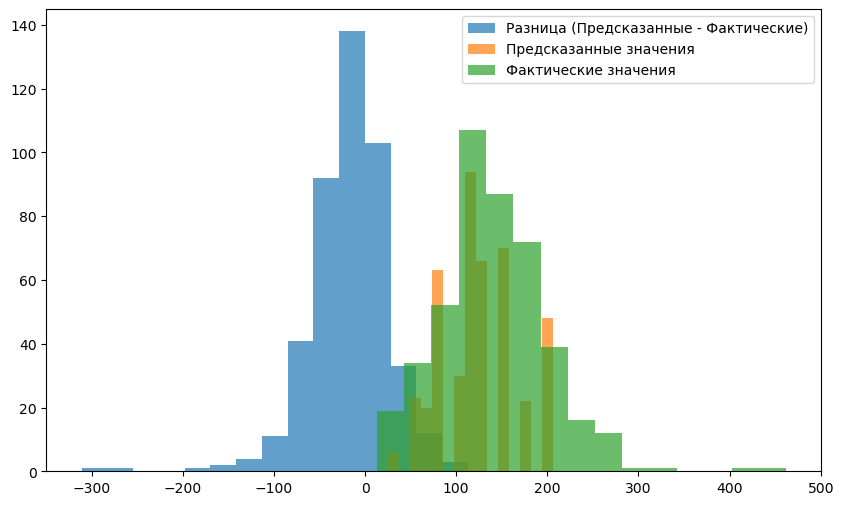

In [24]:
plt.figure(figsize=(10, 6))
plt.hist(y_pred - y_test, bins=15, alpha=0.7, label='Разница (Предсказанные - Фактические)')
plt.hist(y_pred, bins=15, alpha=0.7, label='Предсказанные значения') 
plt.hist(y_test, bins=15, alpha=0.7, label='Фактические значения')
plt.legend()
plt.show()

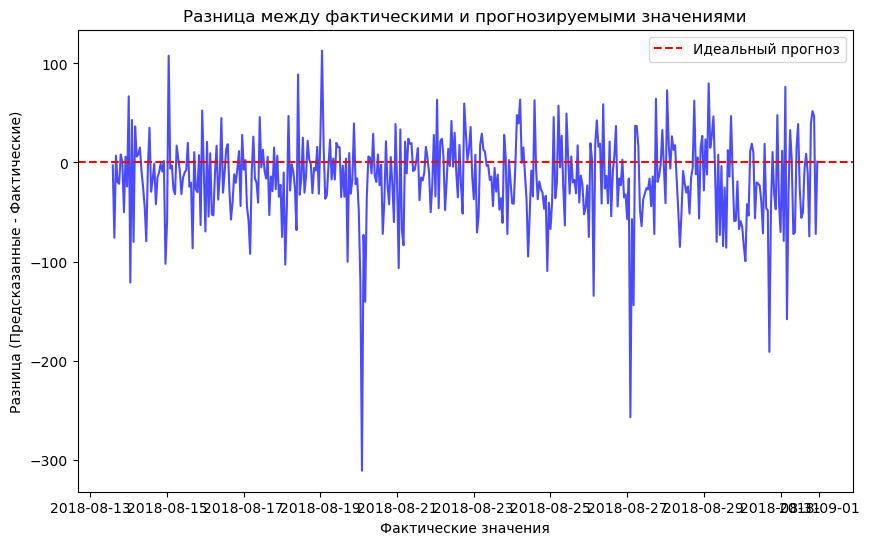

In [25]:
plt.figure(figsize=(10, 6))

plt.plot(y_pred - y_test, alpha=0.7, color="blue")
plt.xlabel("Фактические значения")
plt.ylabel("Разница (Предсказанные - Фактические)")
plt.title("Разница между фактическими и прогнозируемыми значениями")

plt.axhline(y=0, color="red", linestyle="--", label="Идеальный прогноз")  # Линия идеального прогноза

plt.legend()
plt.show()

- Модель занижает прогноз: Точки на графике расположены ниже линии идеального прогноза (y=0), что указывает на то, что модель систематически занижает предсказанные значения.
- Ошибка увеличивается с ростом фактических значений: Чем больше фактическое значение, тем больше разница между прогнозом и фактическим значением. Это говорит о том, что модель не справляется с прогнозированием больших значений.

Из графика видно, что модель сильнее ошибается в следующих участках ряда:

- 2018-08-19 - 2018-08-20. В этом промежутке времени разница между фактическими значениями и прогнозируемыми значениями достигает -300.

- 2018-08-27 - 2018-08-29. В этом промежутке времени разница между фактическими значениями и прогнозируемыми значениями достигает -200.

Модель хорошо предсказывает следующие участки ряда:

- 2018-08-13 - 2018-08-16. В этом промежутке времени разница между фактическими значениями и прогнозируемыми значениями находится в пределах ±50.

- 2018-08-21 - 2018-08-24. В этом промежутке времени разница между фактическими значениями и прогнозируемыми значениями находится в пределах ±50.

- 2018-08-29 - 2018-09-01. В этом промежутке времени разница между фактическими значениями и прогнозируемыми значениями находится в пределах ±50.



<center>Вывод</center>

|Нашли лучшую модель|RMSE|
|---|---|
|DecisionTreeRegressor(max_depth=4, min_samples_leaf=10, min_samples_split=4,random_state=42)|47.04089358738918|

Больше всего вляют на модель признаки
-  "num_month" : тем меньше SHAP‑значения объектов
-  "hour", 'dayofweek: тем больше SHAP‑значения объектов

## Вывод

1. Анализ 

- сделали как индекс - datetime
- Не видим пропуски
- привели столбцы книжнему регистру
- Дубликаты могут быть, поэтому их не удаляем

2.  Исследовательский анализ данных

- максимаольное количество заказов - 119
- минимальное - 0 
и то, и то - возможно, человек может заказывать такси почти каждый день или скачать приложение и не покататься вовсе

3. Треди и сезонность 

- Будем рассматривать такси:
- за 2018 год
- с весны по лето

Тренд:

- Наблюдается положительный тренд, количество заказов постепенно увеличивается с марта по август.
- Тренд не является строго линейным, есть периоды ускорения и замедления.
- Рост числа заказов особенно заметен в мае и июне, а затем немного замедляется в июле, но снова ускоряется в августе.

Сезонность - суточная сезонность:
- Видна периодичность в течение суток, количество заказов больше в ночные часы (возможно, это связано с ночными заказами такси).

Остатки - доля остатков не одинаковая на всем протяжении графика:
- К концу графика доля остатков больше, что может говорить о повышении шума в данных.
- Это может объясняться тем, что тестовая выборка содержит больше данных, которые сложнее объяснить с помощью модели.
- Это может привести к более высокой разнице в RMSE между тренировочной и тестовой выборкой, даже если модель хорошо обучена.

4. Создание признаков

- Сделали признаки:dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
- ADF Statistic: -3.068924
- p-значение теста Дики-Фуллера: 0.028940051402612906
- Ряд стационарный

5. матрица корреляции

- Мультиколинеарности нет, высокие значения там, где нужно

6. 

- Модель занижает прогноз: Точки на графике расположены ниже линии идеального прогноза (y=0), что указывает на то, что модель систематически занижает предсказанные значения.
- Ошибка увеличивается с ростом фактических значений: Чем больше фактическое значение, тем больше разница между прогнозом и фактическим значением. Это говорит о том, что модель не справляется с прогнозированием больших значений.

Из графика видно, что модель сильнее ошибается в следующих участках ряда:

- 2018-08-19 - 2018-08-20. В этом промежутке времени разница между фактическими значениями и прогнозируемыми значениями достигает -300.

- 2018-08-27 - 2018-08-29. В этом промежутке времени разница между фактическими значениями и прогнозируемыми значениями достигает -200.

Модель хорошо предсказывает следующие участки ряда:

- 2018-08-13 - 2018-08-16. В этом промежутке времени разница между фактическими значениями и прогнозируемыми значениями находится в пределах ±50.

- 2018-08-21 - 2018-08-24. В этом промежутке времени разница между фактическими значениями и прогнозируемыми значениями находится в пределах ±50.

- 2018-08-29 - 2018-09-01. В этом промежутке времени разница между фактическими значениями и прогнозируемыми значениями находится в пределах ±50.




Ошибки обьясняюся распределением остатков - доля остатков не одинаковая на всем протяжении графика, что приводит к о повышении шума в данных => имеют ошибки


|Нашли лучшую модель|RMSE тренировочные|RMSE тестовый
|---|---|---|
|DecisionTreeRegressor(max_depth=4, min_samples_leaf=10, min_samples_split=4,random_state=42)|25.221477561370456|47.04089358738918|

Больше всего вляют на модель признаки
- Чем больше значения признаков "lag_168", 'lag_120: тем больше SHAP‑значения объектов
- Чем меньше значения признаков "lag_48", 'lag_32: тем меньше SHAP‑значения объектов

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48